In [123]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image, ImageDraw
from transformers import BertTokenizer, BertPreTrainedModel

from pytorch_pretrained_bert.model_attr import BertPooler, BertModel
from utils import scaled_input

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
BATCH_SIZE = 1
NUM_BATCH = 20

MAX_SEQ_LEN = 128

num_layer = 12
num_head = 12

In [4]:
tokenizer = BertTokenizer.from_pretrained('Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two')

In [150]:
inputs = tokenizer('guilty until proven innocent unless you are a jew a nigger or a lover of both', return_tensors='pt',
                   max_length=MAX_SEQ_LEN, padding='max_length', truncation=True).to(device)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0], skip_special_tokens=False)
label_ids = torch.tensor([0], dtype=torch.long).to(device)

In [151]:
tokens = [token for token in tokens if token not in ['[PAD]']]
tokens

['[CLS]',
 'those',
 'au',
 '##tist',
 '##s',
 'chinese',
 'ching',
 '-',
 'chong',
 '[SEP]']

In [111]:
def generate_attr_score(model, input_ids, segment_ids, attention_mask, label_ids, batch_size, num_batch):
    res_attr = []

    input_len = attention_mask.sum()

    for tar_layer in range(num_layer):
        att, baseline_logits, _ = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=attention_mask,
                                        labels=label_ids, tar_layer=tar_layer)
        pred_label = int(torch.argmax(baseline_logits))

        scale_att, step = scaled_input(att.data, batch_size, num_batch)
        scale_att.requires_grad_(True)

        attr_all = None
        for j_batch in range(num_batch):
            one_batch_att = scale_att[j_batch * batch_size:(j_batch + 1) * batch_size]
            tar_prob, grad = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=attention_mask,
                                   labels=label_ids, tar_layer=tar_layer, tmp_score=one_batch_att,
                                   pred_label=pred_label)
            grad = grad.sum(dim=0)
            attr_all = grad if attr_all is None else torch.add(attr_all, grad)
        attr_all = attr_all[:, 0:input_len, 0:input_len] * step[:, 0:input_len, 0:input_len]
        res_attr.append(attr_all.data)

    return res_attr

In [112]:
class Model_Rational_Label(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = 2
        self.impact_factor = 0.8
        self.bert = BertModel(config, add_pooling_layer=False)
        self.bert_pooler = BertPooler(config)
        self.token_dropout = nn.Dropout(0.1)
        self.token_classifier = nn.Linear(config.hidden_size, 2)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.init_weights()

    def forward(self,
                input_ids=None,
                attention_mask=None,
                token_type_ids=None,
                attn=None,
                labels=None,
                tar_layer=None,
                tmp_score=None,
                pred_label=None):
        _, sequence_output, att_score = self.bert(
            input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask,
            output_all_encoded_layers=False,
            tar_layer=tar_layer, tmp_score=tmp_score)

        token_logits = self.token_classifier(self.token_dropout(sequence_output))

        #         mean_pooling = torch.mean(out, 1)
        #         max_pooling, _ = torch.max(out, 1)
        #         embed = torch.cat((mean_pooling, max_pooling), 1)
        embed = self.bert_pooler(sequence_output)
        logits = self.classifier(self.dropout(embed))

        prob = torch.nn.functional.softmax(logits)

        if labels is not None:
            tar_prob = prob[:, labels[0]]

        if tmp_score is None:
            return att_score[0], logits, token_logits
        else:
            # gradient = torch.autograd.grad(torch.unbind(prob[:, labels[0]]), tmp_score)
            gradient = torch.autograd.grad(torch.unbind(prob[:, pred_label]), tmp_score)
            return tar_prob, gradient[0]

In [65]:
model = Model_Rational_Label.from_pretrained('Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two')
model

Model_Rational_Label(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
     

In [152]:
res_attr = generate_attr_score(
    model,
    inputs['input_ids'],
    inputs['token_type_ids'],
    inputs['attention_mask'],
    label_ids,
    batch_size=BATCH_SIZE,
    num_batch=NUM_BATCH
)
res_attr

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_18589/1247702725.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(logits)


[tensor([[[-2.0300e-04, -6.4041e-05, -4.2954e-05,  ..., -2.2498e-05,
           -2.8121e-05, -4.2386e-04],
          [ 6.6805e-05,  5.0069e-05, -6.1197e-06,  ..., -2.5856e-05,
            1.4633e-05,  7.3369e-06],
          [-1.3476e-05,  1.6611e-06,  2.3442e-05,  ...,  3.9572e-06,
            1.6652e-04, -1.1325e-06],
          ...,
          [-3.8070e-05,  2.8497e-05, -4.7228e-05,  ..., -3.7653e-05,
            1.9099e-05,  3.8078e-06],
          [ 7.3085e-05, -8.2862e-05, -2.1290e-04,  ...,  7.1992e-05,
           -4.5820e-04,  5.8243e-05],
          [ 6.0119e-05,  5.4927e-05,  2.9719e-05,  ..., -6.6231e-05,
            5.0550e-06,  1.8910e-05]],
 
         [[-7.3572e-06,  2.1628e-06,  7.9506e-06,  ...,  6.5338e-05,
            1.7071e-05, -6.5690e-06],
          [ 8.4152e-07,  3.6843e-06,  5.6080e-05,  ..., -1.6092e-07,
           -3.3512e-05,  1.0752e-05],
          [ 7.3090e-05, -2.6699e-07, -6.3467e-06,  ...,  4.4997e-06,
            5.2365e-06, -3.4948e-05],
          ...,
    

In [153]:
np.array(res_attr).shape

(12, 12, 10, 10)

In [154]:
total_attr = np.array(res_attr).sum(axis=0).sum(axis=0)
total_attr = total_attr / total_attr.sum()
total_attr

array([[-2.1495428e-02,  6.9888850e-04,  1.4921614e-02,  1.6908722e-02,
         1.5446926e-02,  3.2103933e-02,  1.5833443e-01,  1.6222546e-01,
         2.6935425e-01, -3.4276985e-02],
       [-3.7867236e-03, -2.1044533e-03,  2.9736052e-03,  1.2291885e-03,
         6.9648330e-03, -1.6035199e-03,  8.7914761e-04,  2.9862805e-03,
        -2.1938961e-03,  2.9692810e-03],
       [ 9.0239486e-03,  5.7178978e-03,  5.6551449e-04,  5.9361099e-03,
         1.6287555e-03,  2.8930949e-03, -5.7441974e-04,  9.5882402e-05,
        -1.0026729e-03,  7.3301597e-03],
       [ 1.2127680e-02, -3.2910691e-03,  2.3171399e-02, -1.0023257e-03,
        -1.7089870e-02, -1.2179839e-03, -2.4094295e-03, -1.5124985e-03,
         3.5924348e-03, -2.1780292e-03],
       [ 5.0741655e-04,  7.2950120e-03,  2.5567501e-03,  4.0952223e-03,
         2.3453755e-03, -4.1430118e-03,  2.3385365e-03,  7.0101698e-05,
         1.4324737e-03, -9.9086657e-04],
       [ 4.4336007e-03,  2.1248059e-03,  4.1414606e-03,  6.0766737e-04,
   

In [155]:
def plot_parallel(matrix, tokens):
    # Set figsize
    plt.figure(figsize=(12, 8))

    input_len = len(tokens)

    # Vertical lines for the years
    plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=5, color='black', linestyle='--', linewidth=1)

    # Add the BEFORE and AFTER
    plt.text(1, input_len + 1, 'A', fontsize=12, color='black', fontweight='bold')
    plt.text(5, input_len + 1, 'B', fontsize=12, color='black', fontweight='bold')

    # Plot the line for each continent
    for i in range(input_len):
        for j in range(input_len):
            # Add the line to the plot
            plt.plot([1, 5], [i, j], marker='o', label='token', color='blue', linewidth=5 * matrix[i][j])

            # Add label of each continent at each year
            plt.text(
                1 - 0.18,  # x-axis position
                i,  # y-axis position
                tokens[i],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color,
            )

            plt.text(
                5 + 0.06,  # x-axis position
                j,  # y-axis position
                tokens[j],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color
            )
        break

    # Add a title ('\n' allow us to jump lines)
    plt.title(f'AttrAttr scores \n\n\n')

    plt.yticks([])  # Remove y-axis
    plt.box(False)  # Remove the bounding box around plot
    plt.show()  # Display the chart

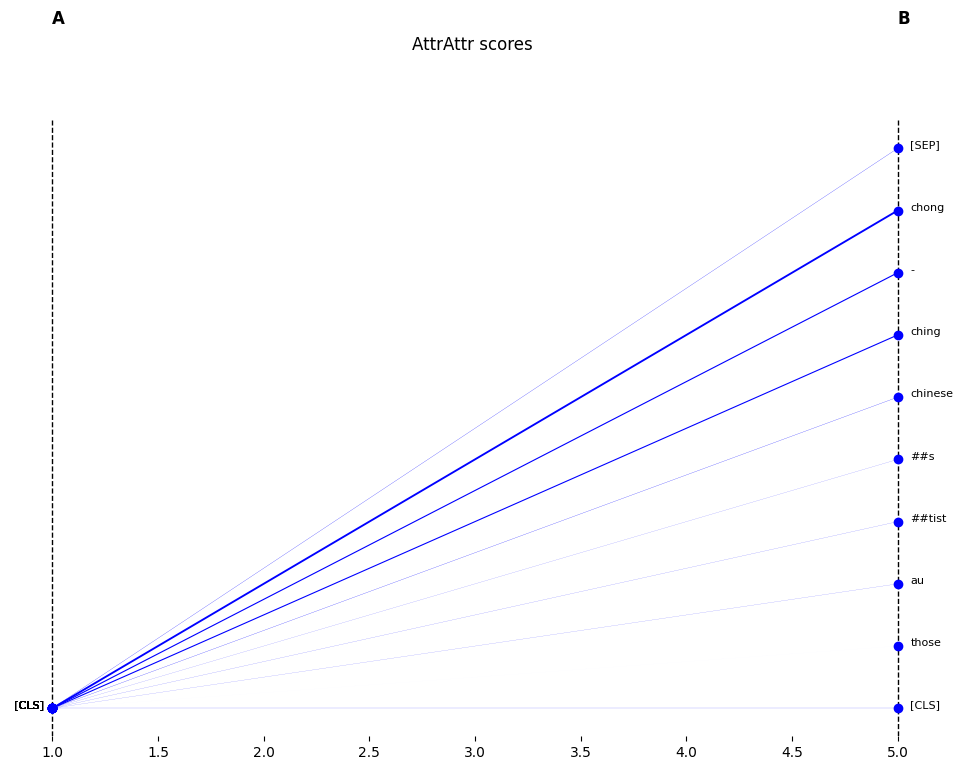

In [156]:
plot_parallel(total_attr, tokens)

In [157]:
_, prediction_logits, token_logits = model(input_ids=inputs['input_ids'], token_type_ids=inputs['token_type_ids'],
                                           attention_mask=inputs['attention_mask'], tar_layer=0)

torch.nn.functional.softmax(prediction_logits)

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_18589/1247702725.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(logits)
/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_18589/2441579763.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(prediction_logits)


tensor([[0.0274, 0.9726]], grad_fn=<SoftmaxBackward0>)

In [158]:
input_len = inputs['attention_mask'].sum()

In [159]:
pred_tokens = torch.nn.functional.softmax(token_logits, dim=-1)[:, :input_len, :]
pred_tokens

tensor([[[9.9929e-01, 7.1052e-04],
         [9.9338e-01, 6.6218e-03],
         [8.7092e-01, 1.2908e-01],
         [9.1110e-01, 8.8896e-02],
         [9.1888e-01, 8.1118e-02],
         [6.8219e-01, 3.1781e-01],
         [3.7816e-02, 9.6218e-01],
         [5.7136e-02, 9.4286e-01],
         [3.2415e-02, 9.6758e-01],
         [9.9995e-01, 5.2039e-05]]], grad_fn=<SliceBackward0>)

In [160]:
id2label = {
    0: 'NEUTRAL',
    1: 'ABUSIVE'
}

In [161]:
tokens_classes = torch.argmax(pred_tokens, dim=2)[0]

In [162]:
for i, token_label in enumerate(tokens_classes):
    print(f'{tokens[i]} ({id2label[token_label.item()]})', end=' ')

[CLS] (NEUTRAL) those (NEUTRAL) au (NEUTRAL) ##tist (NEUTRAL) ##s (NEUTRAL) chinese (NEUTRAL) ching (ABUSIVE) - (ABUSIVE) chong (ABUSIVE) [SEP] (NEUTRAL) 

In [163]:
def generate_text_highlighted(preds, tokens, canvas=(450, 300)):
    im = Image.new(mode='RGBA', size=canvas, color=(255, 255, 255, 255))

    img = ImageDraw.Draw(im)

    def highlight(xy, wh, color):
        img.rectangle(xy=(xy[0] - 0.5, xy[1] - 0.5, xy[0] + wh[0], xy[1] + wh[1]), fill=color)  # , outline='red'

    # highlight((28, 36), wh=(5, 12), color=(255, 0, 0, 100))
    # img.text((28, 36), 'nice Car', fill=(0, 0, 0, 200))

    x = 28
    y = 36
    for i, token in enumerate(tokens):
        if preds[i] == 1:
            x += 3
            highlight((x, y), wh=(6 * len(token), 12), color=(255, 0, 0, 100))
            img.text((x, y), token, fill=(0, 0, 0, 200))
        else:
            img.text((x, y), token, fill=(0, 0, 0, 255))

        x += 1.4 * 5 * len(token)
        if x + 35 >= canvas[0]:
            x = 28
            y += 1.4 * 7

    return im

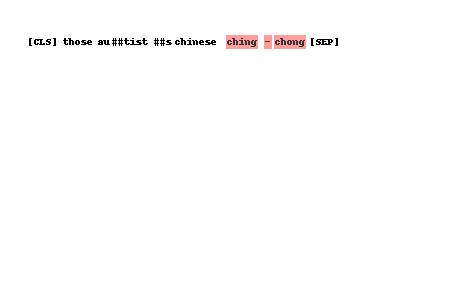

In [164]:
generate_text_highlighted(tokens_classes, tokens)

In [132]:
pred_tokens

tensor([[[9.9875e-01, 1.2473e-03],
         [9.9580e-01, 4.1996e-03],
         [9.9657e-01, 3.4278e-03],
         [9.9555e-01, 4.4473e-03],
         [9.9530e-01, 4.7008e-03],
         [9.7589e-01, 2.4106e-02],
         [9.6882e-01, 3.1180e-02],
         [9.7830e-01, 2.1697e-02],
         [9.7018e-01, 2.9817e-02],
         [3.8503e-01, 6.1497e-01],
         [7.4652e-01, 2.5348e-01],
         [2.2920e-02, 9.7708e-01],
         [1.7939e-02, 9.8206e-01],
         [9.2602e-01, 7.3980e-02],
         [9.7907e-01, 2.0928e-02],
         [8.9924e-01, 1.0076e-01],
         [8.9317e-01, 1.0683e-01],
         [9.5001e-01, 4.9993e-02],
         [9.9996e-01, 4.4781e-05]]], grad_fn=<SliceBackward0>)